# Pylops - seismic inversion

### Author: M.Ravasi

This notebook will focus on running post-stack inversion (for Acoustic Impedence) on GPUs using the Pylops-gpu framework

In [1]:
!pip install pylops
#!pip install git+https://git@github.com/equinor/pylops.git@master
!pip install git+https://git@github.com/equinor/pylops-gpu.git@master

  Cloning https://git@github.com/equinor/pylops-gpu.git (to revision master) to /tmp/pip-req-build-7hpsn7d6
  Running command git clone -q https://git@github.com/equinor/pylops-gpu.git /tmp/pip-req-build-7hpsn7d6
  Created wheel for pylops-gpu: filename=pylops_gpu-0.0.0-cp36-none-any.whl size=29123 sha256=8b267ada1c33622e3a60200430c4a22f88f6f1acb13da5df90903a4e470295ed
  Stored in directory: /tmp/pip-ephem-wheel-cache-jpkr0skg/wheels/c7/f0/0b/513e9be2dad0cbe2a900c0414a94bcae8778093383364aab9a
Successfully built pylops-gpu


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import scipy as sp
import matplotlib.pyplot as plt
import pylops

from scipy.signal import filtfilt
from scipy.sparse.linalg import cg, lsqr
from pylops.utils import dottest
from pylops.utils.wavelets import ricker
from pylops import Diagonal, MatrixMult, FirstDerivative, Laplacian
from pylops.avo.poststack import PoststackLinearModelling
from pylops.optimization.leastsquares import *

from pylops_gpu.utils.backend import device
from pylops_gpu.utils import dottest as gdottest
from pylops_gpu import FirstDerivative as gFirstDerivative
from pylops_gpu import Laplacian as gLaplacian
from pylops_gpu.avo.poststack import PoststackLinearModelling as gPoststackLinearModelling
from pylops_gpu.optimization.cg import cg as gcg
from pylops_gpu.optimization.leastsquares import NormalEquationsInversion as gNormalEquationsInversion

Populating the interactive namespace from numpy and matplotlib


In [3]:
dev = device()
print('PyLops-gpu working on %s...' % dev)

torch.cuda.empty_cache()

PyLops-gpu working on cuda...


## Post-stack inversion - 1D

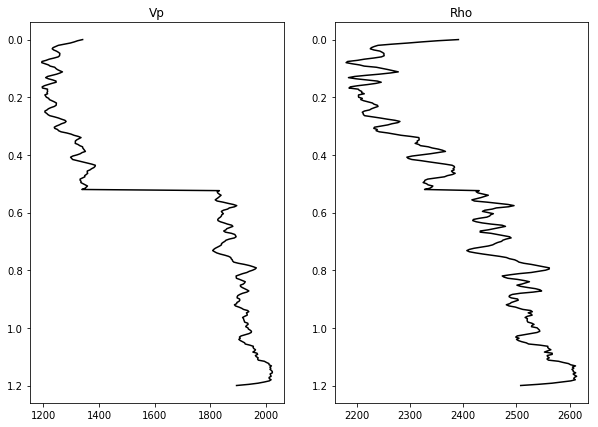

In [4]:
np.random.seed(0)

nt0 = 301
dt0 = 0.004

t0  = np.arange(nt0)*dt0
vp  = 1200 + np.arange(nt0) + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 80, nt0))
rho = 1000 + vp             + filtfilt(np.ones(5)/5.,1,np.random.normal(0, 30, nt0))
vp[131:]+=500
rho[131:]+=100

m1d = np.log(vp*rho).flatten()
m1d = torch.from_numpy(m1d.astype(np.float32)).to(dev)

fig, axs = plt.subplots (1, 2, figsize=(10, 7))
axs[0].plot(vp,  t0, 'k')
axs[0].set_title('Vp')
axs[0].invert_yaxis()
axs[1].plot(rho, t0, 'k')
axs[1].set_title('Rho')
axs[1].invert_yaxis()

In [0]:
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

In [6]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)).to(dev), nt0=nt0, 
                                device=dev)
gdottest(PPop, nt0, nt0, device=dev, verb=True, tol=1e-4)

# dense
PPop_dense = gPoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True, 
                                      device=dev)
gdottest(PPop_dense, nt0, nt0, device=dev, verb=True, tol=1e-4)

# pylops
PPop_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0)
dottest(PPop_pylops, nt0, nt0, verb=True, tol=1e-4)

# pylops
PPop_dense_pylops = PoststackLinearModelling(wav.astype(np.float32), nt0=nt0, explicit=True)
dottest(PPop_dense_pylops, nt0, nt0, verb=True, tol=1e-4)

# data
d = PPop * m1d
d_dense = PPop_dense * m1d
d_pylops = PPop_pylops * m1d.cpu().numpy()
d_dense_pylops = PPop_dense_pylops * m1d.cpu().numpy()

Dot test passed, v^T(Opu)=0.278902 - u^T(Op^Tv)=0.278901
Dot test passed, v^T(Opu)=-15.865685 - u^T(Op^Tv)=-15.865681
Dot test passed, v^T(Opu)=-6.815360 - u^T(Op^Tv)=-6.815360
Dot test passed, v^T(Opu)=9.496557 - u^T(Op^Tv)=9.496557


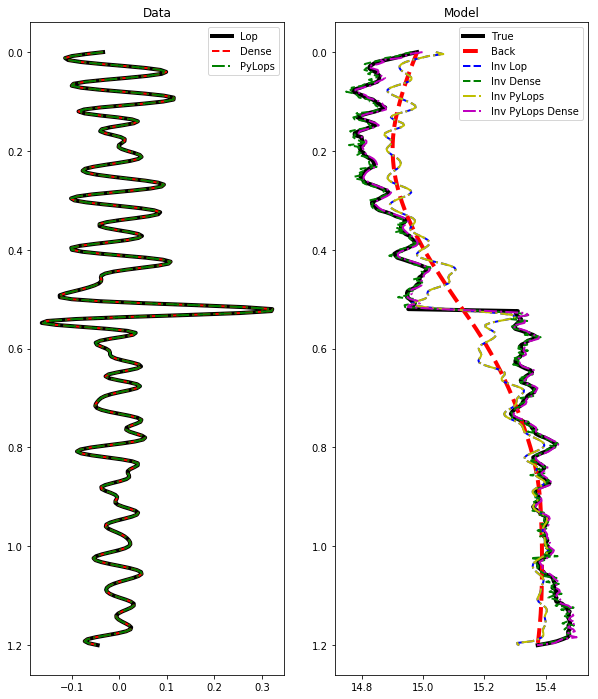

In [7]:
nsmooth = 100
m1dback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m1d.cpu().numpy())
m1dback = torch.from_numpy(m1dback.astype(np.float32)).to(dev)

# solve lop
d0 = PPop * m1dback
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr, niter=10)[0]
minv = m1dback + minv

# solve pylops lop
d0_pylops = PPop_pylops * m1dback.cpu().numpy()
dr_pylops = d.cpu().numpy() - d0.cpu().numpy()
minv_pylops = cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=10)[0]
minv_pylops = m1dback.cpu().numpy() + minv_pylops

# solve dense
d0_dense = PPop*m1dback
dr_dense = d_dense - d0_dense
minv_dense = torch.solve(dr_dense.reshape(nt0, 1) , 
                         PPop_dense.A.reshape(nt0, nt0) + 1e-4*torch.eye(nt0, dtype=torch.float32).to(dev)).solution.flatten()
minv_dense = m1dback + minv_dense

# solve dense pylops
d0_pylops_dense = PPop_dense_pylops*m1dback.cpu().numpy()
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense, rcond=1e-5)[0]
#minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_pylops_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = m1dback.cpu().numpy() + minv_pylops_dense

fig, axs = plt.subplots(1, 2, figsize=(10, 12))
axs[0].plot(d.cpu().numpy(), t0, 'k', lw=4, label='Lop')
axs[0].plot(d_dense.cpu().numpy(), t0,'--r', lw=2, label='Dense')
axs[0].plot(d_pylops, t0,'-.g', lw=2, label='PyLops')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend()
axs[1].plot(m1d.cpu().numpy(), t0, 'k', lw=4, label='True')
axs[1].plot(m1dback.cpu().numpy(), t0, '--r', lw=4, label='Back')
axs[1].plot(minv.cpu().numpy(), t0, '--b', lw=2, label='Inv Lop')
axs[1].plot(minv_dense.cpu().numpy(), t0, '--g', lw=2, label='Inv Dense')
axs[1].plot(minv_pylops, t0, '-.y', lw=2, label='Inv PyLops')
axs[1].plot(minv_pylops_dense, t0, '-.m', lw=2, label='Inv PyLops Dense')
axs[1].set_title('Model')
axs[1].invert_yaxis()
axs[1].axis('tight')
axs[1].legend();

In [8]:
%timeit -r 3 -n 10 cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops, maxiter=50)[0]
%timeit -r 3 -n 10 gcg(PPop.H * PPop, PPop.H * dr, niter=50)[0]

10 loops, best of 3: 31.3 ms per loop
10 loops, best of 3: 32.3 ms per loop


So far no improvement by moving from CPU to GPU....

## Post-stack inversion - 2D

In [0]:
#from google.colab import files
#files.upload()

In [0]:
# local
#inputfile='../data/avo/poststack_model.npz'
# colab (after uploading) 
inputfile='poststack_model.npz'

model = np.load(inputfile)
x, z, m = model['x'], model['z'], np.log(model['model'])
nx, nz = len(x), len(z)

m = torch.from_numpy(m.astype(np.float32)).to(dev)

Create operators

In [11]:
# lop
PPop = gPoststackLinearModelling(torch.from_numpy(wav.astype(np.float32)).to(dev),
                                 nt0=nz, spatdims=nx, explicit=False,
                                 device=dev)
gdottest(PPop, nz*nx, nz*nx, device=dev, verb=True, tol=1e-3)

# dense
PPop_dense = gPoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True, device=dev)
gdottest(PPop_dense, nz*nx, nz*nx, device=dev, verb=True, tol=1e-3)

# lop
PPop_pylops = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=False)
dottest(PPop_pylops, nz*nx, nz*nx, verb=True, tol=1e-3)

# dense
PPop_dense_pylops = PoststackLinearModelling(wav, nt0=nz, spatdims=nx, explicit=True)
dottest(PPop_dense_pylops, nz*nx, nz*nx, verb=True, tol=1e-3)

# data
d = (PPop * m.flatten()).reshape(nz, nx)
d_dense = (PPop_dense*m.flatten()).reshape(nz,nx)
d_pylops = (PPop_pylops * m.cpu().numpy().flatten()).reshape(nz,nx)
d_dense_pylops = (PPop_dense_pylops * m.cpu().numpy().flatten()).reshape(nz,nx)

Dot test passed, v^T(Opu)=-1218.321655 - u^T(Op^Tv)=-1218.322266
Dot test passed, v^T(Opu)=1043.912231 - u^T(Op^Tv)=1043.912109
Dot test passed, v^T(Opu)=713.756415 - u^T(Op^Tv)=713.756415
Dot test passed, v^T(Opu)=-919.826089 - u^T(Op^Tv)=-919.826089


Background model

In [0]:
nsmooth = 60
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m.cpu().numpy(), axis=0)
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, mback, axis=1)
mback = torch.from_numpy(mback.astype(np.float32)).to(dev)

d0 = (PPop*mback.flatten()).reshape(nz,nx)
d0_dense = (PPop_dense*mback.flatten()).reshape(nz,nx)
d0_pylops = (PPop_pylops * mback.cpu().numpy().flatten()).reshape(nz,nx)
d0_pylops_dense = (PPop_dense_pylops*mback.cpu().numpy().flatten()).reshape(nz,nx)

Solve unconstrained problem

In [0]:
# solve lop
dr = d - d0
minv = gcg(PPop.H * PPop, PPop.H * dr.flatten(), niter=100)[0]
minv = mback + minv.reshape(nz,nx)

# solve pylops lop
dr_pylops = d_pylops - d0_pylops
minv_pylops = cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops.flatten(),
                 maxiter=100)[0]
minv_pylops = mback.cpu().numpy() + minv_pylops.reshape(nz,nx)

# solve dense
dr_dense = d_dense - d0_dense
minv_dense = torch.solve(dr_dense.reshape(nz, nx) , 
                         PPop_dense.A + 1e-3*torch.eye(nz, dtype=torch.float32).to(dev)).solution
minv_dense = mback + minv_dense.reshape(nz,nx)

# solve dense pylops
dr_pylops_dense = d_dense_pylops - d0_pylops_dense
minv_pylops_dense = lstsq(PPop_dense_pylops.A, dr_pylops_dense)[0]
minv_pylops_dense = lstsq(PPop_dense.A.cpu().numpy(), dr_dense.cpu().numpy(), rcond=1e-5)[0]
minv_pylops_dense = mback.cpu().numpy() + minv_pylops_dense.reshape(nz,nx)

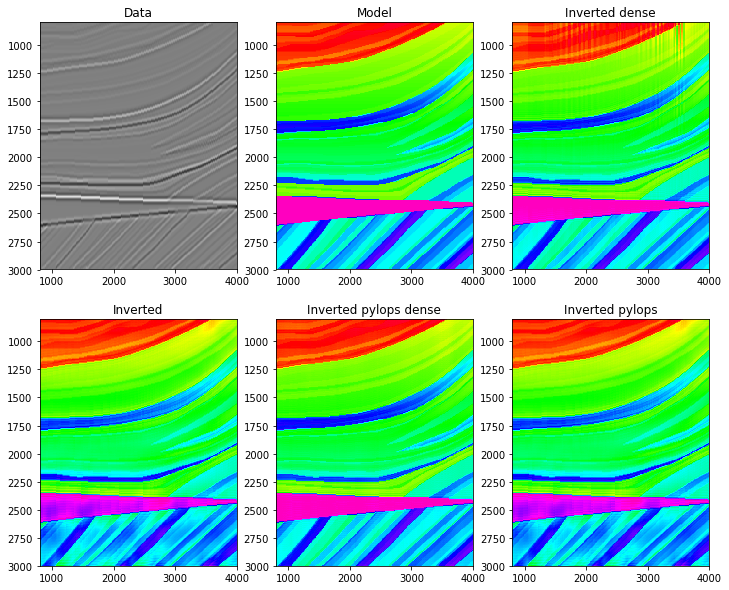

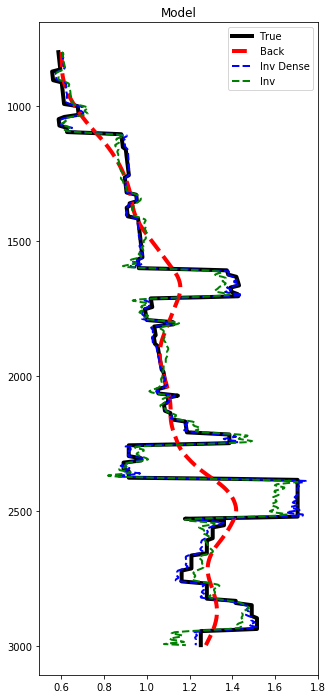

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(12, 10))
axs[0][0].imshow(d.cpu(), cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(m.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][1].set_title('Model')
axs[0][1].axis('tight')
axs[0][2].imshow(minv_dense.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Inverted dense')
axs[0][2].axis('tight')
axs[1][0].imshow(minv.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Inverted')
axs[1][0].axis('tight');
axs[1][1].imshow(minv_pylops_dense, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Inverted pylops dense')
axs[1][1].axis('tight');
axs[1][2].imshow(minv_pylops, cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Inverted pylops')
axs[1][2].axis('tight');


fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2].cpu().numpy(), z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2].cpu().numpy(), z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2].cpu().numpy(), z, '--b', lw=2, label='Inv Dense')
ax.plot(minv[:,nx//2].cpu().numpy(), z, '--g', lw=2, label='Inv')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

In [15]:
%timeit -r 3 -n 3 gcg(PPop.H * PPop, PPop.H * dr.flatten(), niter=10)[0]
%timeit -r 3 -n 3 cg(PPop_pylops.H * PPop_pylops, PPop_pylops.H * dr_pylops.flatten(), maxiter=10)[0]

3 loops, best of 3: 27.7 ms per loop
3 loops, best of 3: 875 ms per loop


Solve constrained problem

In [0]:
# solve all rows together with regularization
gD2op  = gLaplacian([nz, nx], device=dev, dtype=torch.float32)
gdottest(gD2op, nz*nx, nz*nx, device=dev, dtype=torch.float32, tol=1e-3)
D2op  = Laplacian([nz, nx])

minv_dense_reg = gNormalEquationsInversion(PPop_dense, [gD2op], dr_dense.flatten(),
                                           epsRs=[np.sqrt(1e-4)], 
                                           returninfo=False, device=dev, 
                                           **dict(niter=100))
minv_dense_reg = mback + minv_dense_reg.reshape(nz, nx)

minv_reg = gNormalEquationsInversion(PPop, [gD2op], dr_dense.flatten(),
                                     epsRs=[np.sqrt(1e-4)], 
                                     returninfo=False, device=dev, 
                                     **dict(niter=100))
minv_reg = mback + minv_reg.reshape(nz, nx)

minv_reg_pylops = NormalEquationsInversion(PPop_pylops, [D2op], dr_dense.cpu().numpy().flatten(),
                                           epsRs=[np.sqrt(1e-4)], returninfo=False,
                                           **dict(maxiter=100))
minv_reg_pylops = mback.cpu().numpy() + minv_reg_pylops.reshape(nz, nx)

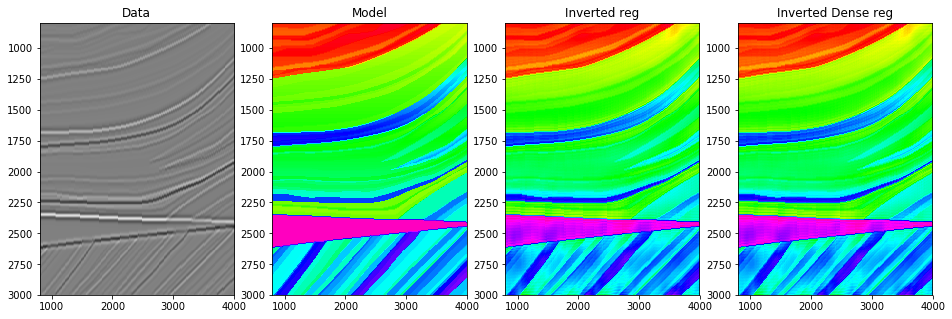

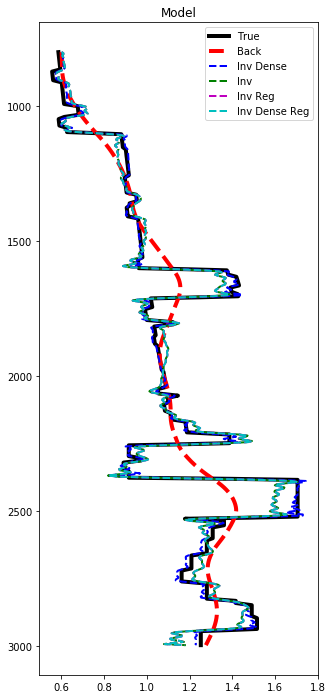

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))
axs[0].imshow(d.cpu(), cmap='gray', extent = (x[0], x[-1], z[-1], z[0]), vmin=-1, vmax=1)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(m.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1].set_title('Model')
axs[1].axis('tight')
axs[2].imshow(minv_reg.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[2].set_title('Inverted reg')
axs[2].axis('tight')
axs[3].imshow(minv_dense_reg.cpu(), cmap='gist_rainbow', extent = (x[0], x[-1], z[-1], z[0]),
              vmin=m.min(), vmax=m.max())
axs[3].set_title('Inverted Dense reg')
axs[3].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(5, 12))
ax.plot(m[:,nx//2].cpu().numpy(), z, 'k', lw=4, label='True')
ax.plot(mback[:,nx//2].cpu().numpy(), z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:,nx//2].cpu().numpy(), z, '--b', lw=2, label='Inv Dense')
ax.plot(minv[:,nx//2].cpu().numpy(), z, '--g', lw=2, label='Inv')
ax.plot(minv_dense_reg[:,nx//2].cpu().numpy(), z, '--m', lw=2, label='Inv Reg')
ax.plot(minv_reg[:,nx//2].cpu().numpy(), z, '--c', lw=2, label='Inv Dense Reg')

ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend();

In [18]:
%timeit -r 3 -n 3 gNormalEquationsInversion(PPop, [gD2op], dr_dense.flatten(), epsRs=[np.sqrt(1e-4)], dataregs=[torch.zeros(nz*nx, dtype=torch.float32).to(dev)], returninfo=False, **dict(niter=100))
%timeit -r 3 -n 3 NormalEquationsInversion(PPop_pylops, [D2op], dr_dense.cpu().numpy().flatten(), epsRs=[np.sqrt(1e-4)], returninfo=False, **dict(maxiter=100))

%timeit -r 3 -n 3 gNormalEquationsInversion(PPop_dense, [gD2op], dr_dense.flatten(), epsRs=[np.sqrt(1e-4)], dataregs=[torch.zeros(nz*nx, dtype=torch.float32).to(dev)], returninfo=False, **dict(niter=100))
%timeit -r 3 -n 3 NormalEquationsInversion(PPop_dense_pylops, [D2op], dr_dense.cpu().numpy().flatten(), epsRs=[np.sqrt(1e-4)], returninfo=False, **dict(maxiter=100))

3 loops, best of 3: 308 ms per loop
3 loops, best of 3: 10.2 s per loop
3 loops, best of 3: 163 ms per loop
3 loops, best of 3: 6.15 s per loop


But things change drammatically when we invert a big model with multiple vertical pillars... now the GPU run is about 35 times faster!